In [2]:
import json
import os 
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import torch
import torch.nn as nn
from collections import defaultdict
import re

def extract_timestapm_from_json(json_path):
    with open(json_path, 'r') as file:
        json_data = file.read()
    data = json.loads(json_data)
    timestamp_match = re.search(r'\\(\d{4}-\d{2}-\d{2}_\d{6})\\', data['checkpoint'])
    timestamp = None
    if timestamp_match:
        timestamp = timestamp_match.group(1)
        return timestamp
    return -1

c:\Users\danko\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def dino_sim(rendered_path, original_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
    model = AutoModel.from_pretrained('facebook/dinov2-base').to(device)

    dic = defaultdict(int)
    total_similarity = 0.0
    total_images = 0
    average_similarity = 0

    for rendered_img_name in os.listdir(rendered_path):
        if "full" in rendered_img_name:
            # print(rendered_img_name)
            rendered_img_path = os.path.join(rendered_path, rendered_img_name)
            id = int(rendered_img_name.split("_")[3].split("-")[0])
            matching_images = [image for image in os.listdir(original_path) if str(id) in image]
            
            if not matching_images:
                print(f"No corresponding image found for {rendered_img_name}")
                continue

            # Take the first matching image
            image_path2 = os.path.join(original_path, matching_images[0])

            image1 = Image.open(rendered_img_path)
            image2 = Image.open(image_path2)

            with torch.no_grad():
                inputs1 = processor(images=image1, return_tensors='pt').to(device)
                outputs1 = model(**inputs1)
                image_features1 = outputs1.last_hidden_state.mean(dim=1)

                inputs2 = processor(images=image2, return_tensors='pt').to(device)
                outputs2 = model(**inputs2)
                image_features2 = outputs2.last_hidden_state.mean(dim=1)

            cos = nn.CosineSimilarity(dim=0)
            sim = cos(image_features1[0], image_features2[0]).item()
            sim = (sim + 1) / 2
            dic[rendered_img_name] = sim
            total_similarity += sim
            total_images += 1

            # print(f"Similarity for {rendered_img_name}: {sim}")

    if total_images > 0:
        average_similarity = total_similarity / total_images
        return average_similarity
    else:
        return -5

# Example usage:
original_path = 'C:\Stuff\Dataset-creation\data\stump\images'
rendered_path = 'C:\Stuff\Dataset-creation\\renders\\2024-01-07_021816'
dino_sim(rendered_path, original_path)

preprocessor_config.json: 100%|██████████| 436/436 [00:00<?, ?B/s] 
c:\Users\danko\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\danko\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
config.json: 100%|██████████| 548/548 [00:00<?, ?B/

0.898174978354398

In [5]:
path_jsons = 'C:\Stuff\Dataset-creation\jsons'
json_files = [os.path.join(path_jsons, f) for f in os.listdir(path_jsons) if f.endswith('.json')]

dino_sim_value = []
path_renders = "C:\Stuff\Dataset-creation\\renders"
original_path = 'C:\Stuff\Dataset-creation\data\stump\images'
for json_file in json_files:
    timestamp = extract_timestapm_from_json(json_file)
    folder_renders = os.path.join(path_renders, timestamp)
    if not os.path.exists(folder_renders):
        dino_sim_score = -1
        print(f'{json_file} : {dino_sim_score}')
    else:
        try:
            dino_sim_score = dino_sim(folder_renders, original_path=original_path)
        except:
            print(folder_renders, json_file)
        print(f'{json_file} : {dino_sim_score}')

C:\Stuff\Dataset-creation\renders\2024-01-14_025116 C:\Stuff\Dataset-creation\jsons\stump-every-2.json


NameError: name 'dino_sim_score' is not defined

In [6]:
# Benchmark values for PSNR, SSIM, and LPIPS
benchmark_psnr = 22.115245819091797
benchmark_psnr_std = 1.542604923248291
benchmark_ssim = 0.654498815536499
benchmark_lpips = 0.44680535793304443

def extract_metrics(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)

    psnr = data['results']['psnr']
    ssim = data['results']['ssim']
    lpips = data['results']['lpips']

    psnr_std = data['results']['psnr_std']
    ssim_std = data['results']['ssim_std']
    lpips_std = data['results']['lpips_std']

    return psnr, ssim, lpips, psnr_std, ssim_std, lpips_std

def create_latex_table(experiment_names, psnr_values, ssim_values, lpips_values, delta_psnr, delta_ssim, delta_lpips, dino_values):
    # latex_table = "\\begin{tabular}{c|c|c|c|c|c|c}\n"
    # latex_table += "\\hline\n"
    # latex_table += "Experiment & PSNR & $\\Delta$ PSNR & SSIM & $\\Delta$ SSIM & LPIPS & $\\Delta$ LPIPS \\\\\n"
    # latex_table += "\\hline\n"
    
    latex_table = "\\begin{tabular}{c|c|c|c|c|c|c|c|c}\n"  # Added a new column for relative change in PSNR
    latex_table += "Experiment & PSNR & $\\Delta$ PSNR & Rel. Change & SSIM & $\\Delta$ SSIM & LPIPS & $\\Delta$ LPIPS & DINO Sim. \\\\\n"
    latex_table += "\\hline\n"


    for exp, psnr, ssim, lpips, delta_p, delta_s, delta_l, dino_val in zip(
        experiment_names, psnr_values, ssim_values, lpips_values, delta_psnr, delta_ssim, delta_lpips, dino_values
    ):
        exp = os.path.basename(exp)
        # latex_table += f"{exp} & {psnr:.4f} & {delta_p:.4f} & {ssim:.4f} & {delta_s:.4f} & {lpips:.4f} & {delta_l:.4f} \\\\\n"
        
        relative_delta_psnr = (delta_p / benchmark_psnr)*100  # Calculate relative change in PSNR
        latex_table += f"{exp} & {psnr:.4f} & {delta_p:.4f} & {relative_delta_psnr:.3f}\% & {ssim:.4f} & {delta_s:.4f} & {lpips:.4f} & {delta_l:.4f} & {dino_val:.4f} \\\\\n"


    # latex_table += "\\hline\n"
    latex_table += "\\end{tabular}"

    return latex_table

def calculate_deltas(values, benchmark):
    return [value - benchmark for value in values]

path_jsons = 'C:\Stuff\Dataset-creation\jsons'
path_renders = "C:\Stuff\Dataset-creation\\renders"
json_files = [os.path.join(path_jsons, f) for f in os.listdir(path_jsons) if f.endswith('.json')]

experiment_names = [os.path.splitext(file)[0] for file in json_files]
psnr_values, ssim_values, lpips_values, dino_values = [], [], [], []
psnr_stds, ssim_stds, lpips_stds = [], [], []
delta_psnr, delta_ssim, delta_lpips = [], [], []
data = []

for i, json_file in enumerate(json_files):
    psnr, ssim, lpips, psnr_std, ssim_std, lpips_std = extract_metrics(json_file)
    psnr_values.append(psnr)
    ssim_values.append(ssim)
    lpips_values.append(lpips)

    psnr_stds.append(psnr_std)
    ssim_stds.append(ssim_std)
    lpips_stds.append(lpips_std)
    
    exp = os.path.basename(experiment_names[i])
    data.append([exp, psnr, psnr_std])
    # data.append([exp, psnr])



    # timestamp = extract_timestapm_from_json(json_file)
    # print(timestamp)
    # folder_renders = os.path.join(path_renders, timestamp)
    # if not os.path.exists(folder_renders):
    #     dino_sim_score = -1
    # else:
    #     dino_sim_score = dino_sim(folder_renders, original_path=original_path)
    # dino_values.append(dino_sim_score)

    dino_values.append(-1)

delta_psnr = calculate_deltas(psnr_values, benchmark_psnr)
delta_ssim = calculate_deltas(ssim_values, benchmark_ssim)
delta_lpips = calculate_deltas(lpips_values, benchmark_lpips)

latex_table = create_latex_table(
    experiment_names, psnr_values, ssim_values, lpips_values, delta_psnr, delta_ssim, delta_lpips, dino_values
)

print(latex_table)

\begin{tabular}{c|c|c|c|c|c|c|c|c}
Experiment & PSNR & $\Delta$ PSNR & Rel. Change & SSIM & $\Delta$ SSIM & LPIPS & $\Delta$ LPIPS & DINO Sim. \\
\hline
stump-every-2 & 21.6473 & -0.4680 & -2.116\% & 0.6184 & -0.0361 & 0.4943 & 0.0475 & -1.0000 \\
stump-every-3 & 21.8086 & -0.3067 & -1.387\% & 0.6259 & -0.0286 & 0.4800 & 0.0332 & -1.0000 \\
stump-every-4 & 21.0596 & -1.0556 & -4.773\% & 0.5991 & -0.0554 & 0.4698 & 0.0230 & -1.0000 \\
stump-every-5 & 20.9125 & -1.2028 & -5.439\% & 0.5888 & -0.0657 & 0.4785 & 0.0317 & -1.0000 \\
stump-every-6 & 21.7286 & -0.3867 & -1.748\% & 0.6185 & -0.0360 & 0.4769 & 0.0301 & -1.0000 \\
stump-every-7 & 11.9699 & -10.1454 & -45.875\% & 0.4483 & -0.2062 & 0.8898 & 0.4429 & -1.0000 \\
stump-every-8 & 12.3464 & -9.7688 & -44.172\% & 0.4472 & -0.2073 & 0.8674 & 0.4206 & -1.0000 \\
stump-gamma-10 & 21.7245 & -0.3908 & -1.767\% & 0.6242 & -0.0303 & 0.5226 & 0.0758 & -1.0000 \\
stump-gamma-15 & 21.8360 & -0.2792 & -1.263\% & 0.6250 & -0.0294 & 0.5221 & 0.0753 

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Sample data
# x = np.linspace(0, 10, 100)
# y_mean = np.sin(x)
# y_std = 0.2  # Example standard deviation

# # Plotting
# plt.plot(x, y_mean, label='Mean')
# plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, label='Standard Deviation')
# plt.legend()
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Line Graph with Shaded Standard Deviation')
# plt.show()


In [13]:
data

[['stump-every-2', 21.64728546142578, 1.542604923248291],
 ['stump-every-3', 21.8085880279541, 1.4704761505126953],
 ['stump-every-4', 21.059648513793945, 1.1445002555847168],
 ['stump-every-5', 20.9124813079834, 1.2797290086746216],
 ['stump-every-6', 21.72856903076172, 1.4608336687088013],
 ['stump-every-7', 11.96985912322998, 1.628631591796875],
 ['stump-every-8', 12.346437454223633, 1.0671874284744263],
 ['stump-gamma-10', 21.724464416503906, 1.6829808950424194],
 ['stump-gamma-15', 21.836017608642578, 1.5480400323867798],
 ['stump-gamma-20', 21.741079330444336, 1.9427003860473633],
 ['stump-gamma-25', 21.799823760986328, 1.5808656215667725],
 ['stump-gamma-30', 21.982891082763672, 1.4568214416503906],
 ['stump-gamma-35', 21.94118881225586, 1.6518127918243408],
 ['stump-gamma-40', 21.598922729492188, 1.67698335647583],
 ['stump-gamma-5', 21.65592384338379, 1.6678190231323242],
 ['stump-noise-std-112', 19.161306381225586, 0.6703628301620483],
 ['stump-noise-std-128', 18.055652618408

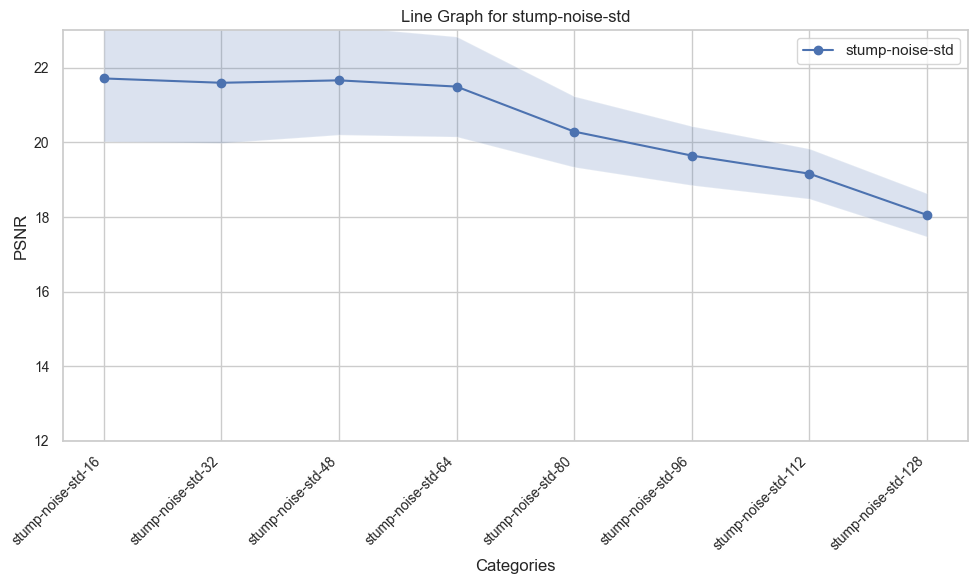

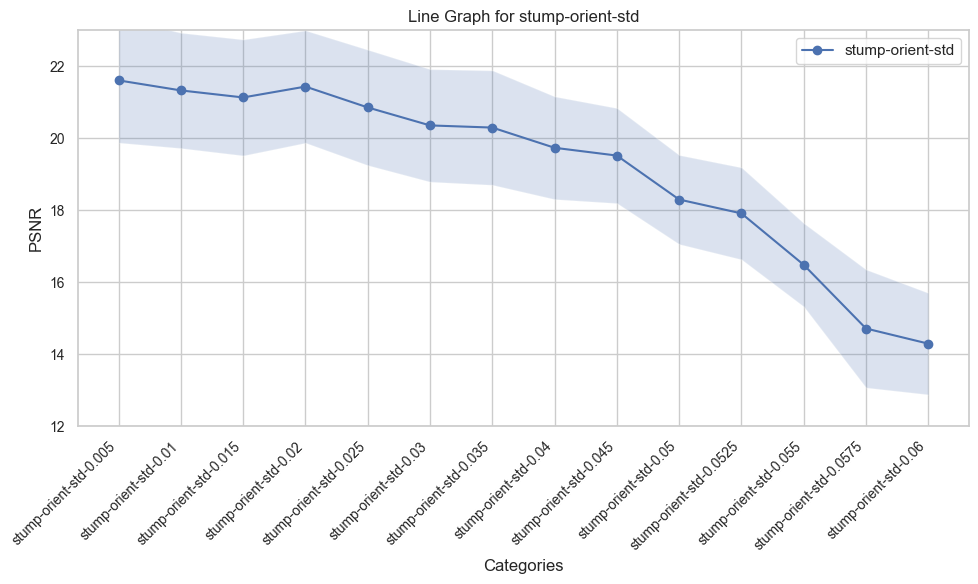

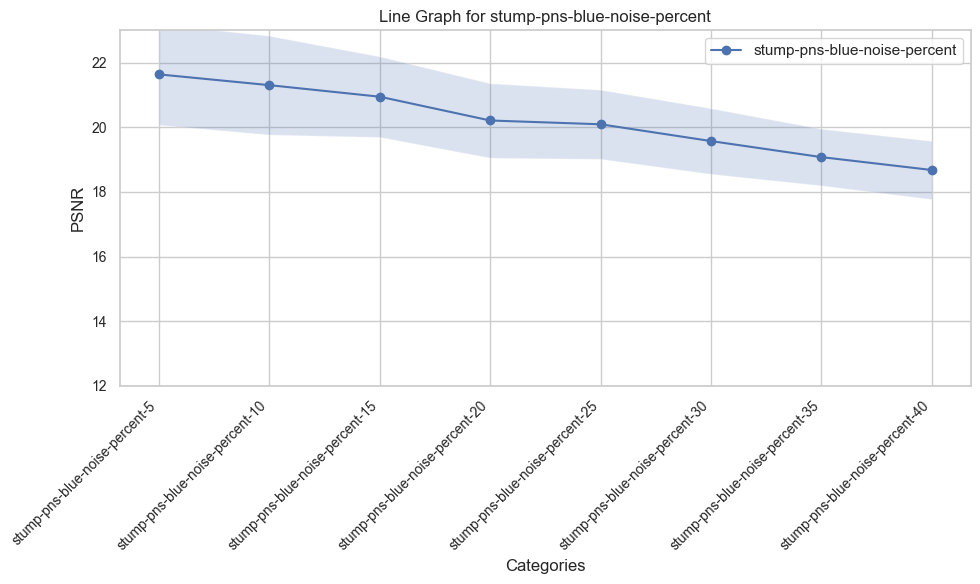

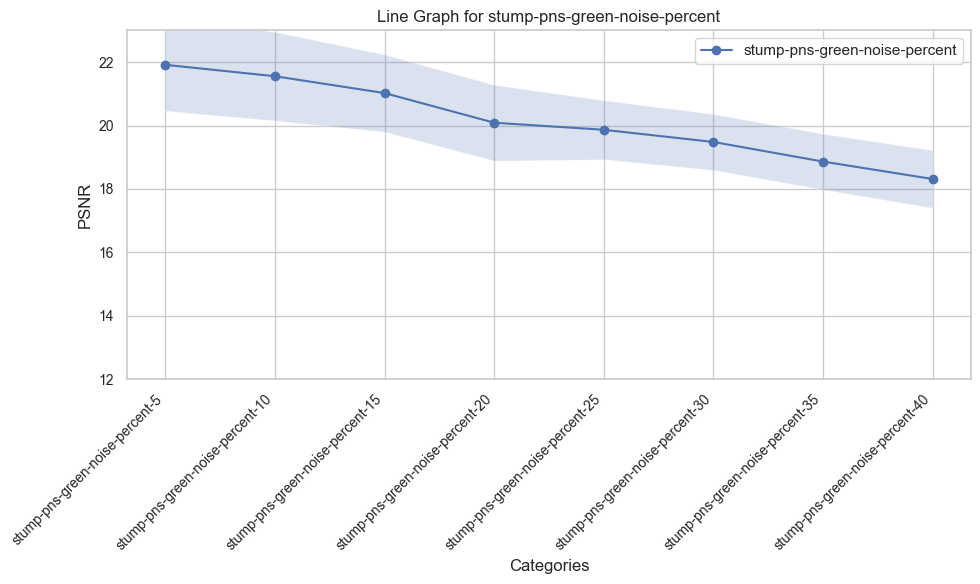

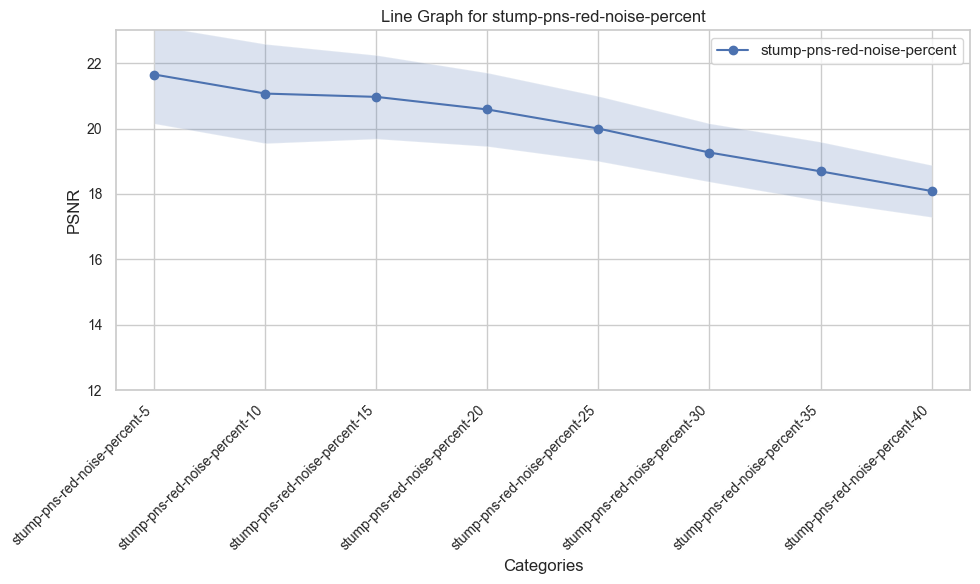

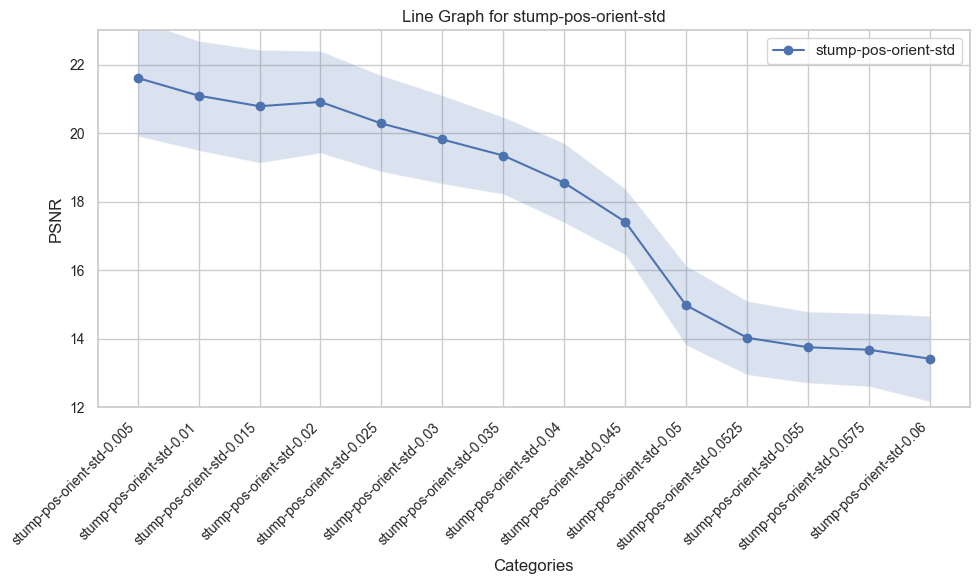

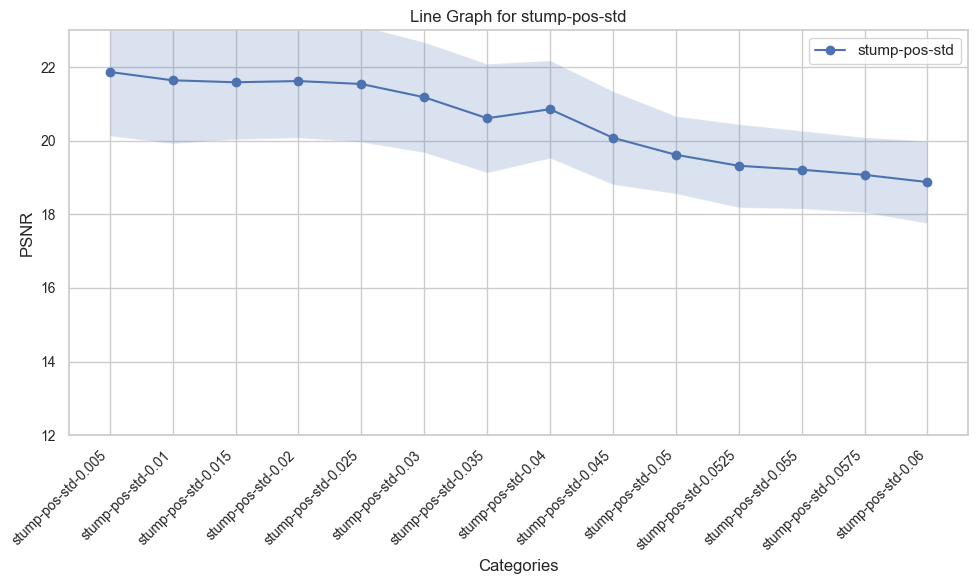

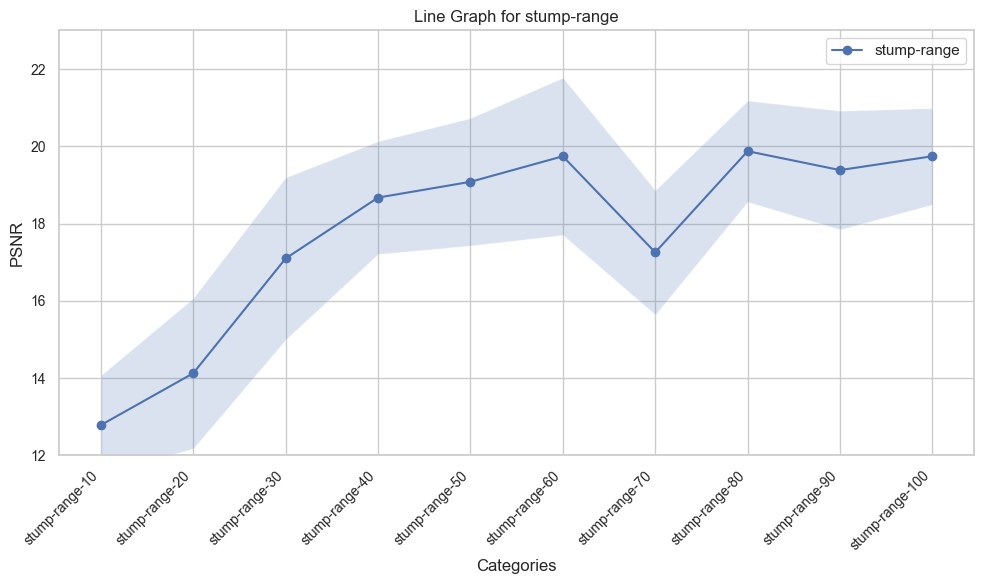

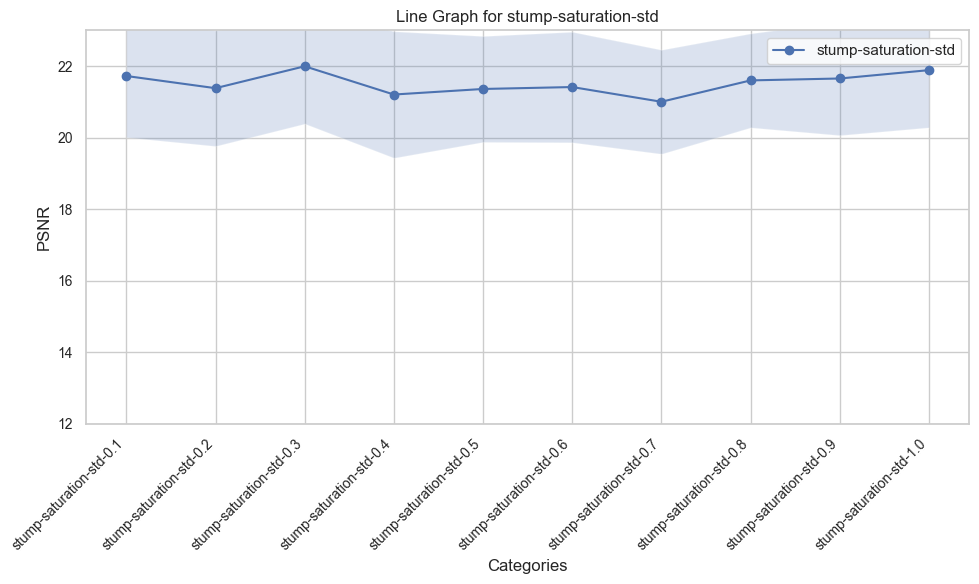

In [7]:
# Create separate subplots for each type
import matplotlib.pyplot as plt
import seaborn as sns

types = ['stump-noise-std', 'stump-orient-std', 'stump-pns-blue-noise-percent', 'stump-pns-green-noise-percent', 
         'stump-pns-red-noise-percent', 'stump-pos-orient-std', 'stump-pos-std', 'stump-range', 
         'stump-saturation-std']
# Set Seaborn style
# sns.set(style="whitegrid")
sns.set(style="whitegrid", rc={"axes.labelsize": 12, "xtick.labelsize": 10, "ytick.labelsize": 10})

sorted_data = sorted(data, key=lambda x: (x[0].split('-')[1], float(x[0].split('-')[-1]), x[1]))
for type_name in types:
    type_data = [item for item in sorted_data if type_name in item[0]]
    # categories, values, _ = zip(*type_data)
    categories, values, stds = zip(*type_data)

    
    plt.figure(figsize=(10, 6))
    # sns.lineplot(x=categories, y=values, marker='o', label=type_name)
    plt.plot(categories, values, marker='o', linestyle='-', label=type_name)
    # plt.fill_between(categories, values - stds, values + stds, alpha=0.2, label='Standard Deviation')
    plt.fill_between(categories, [value - std for value, std in zip(values, stds)], [value + std for value, std in zip(values, stds)], alpha=0.2)

    plt.ylim(12, 23)  # Set y-axis limits
    plt.xlabel('Categories')
    plt.ylabel('PSNR')
    plt.title(f'Line Graph for {type_name}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.legend()
    plt.tight_layout()



    # output_file = os.path.join('C:\Stuff\Dataset-creation\plots', f'{type_name}_plot.png')
    # plt.savefig(output_file)

    plt.show()
    # print(type_data)

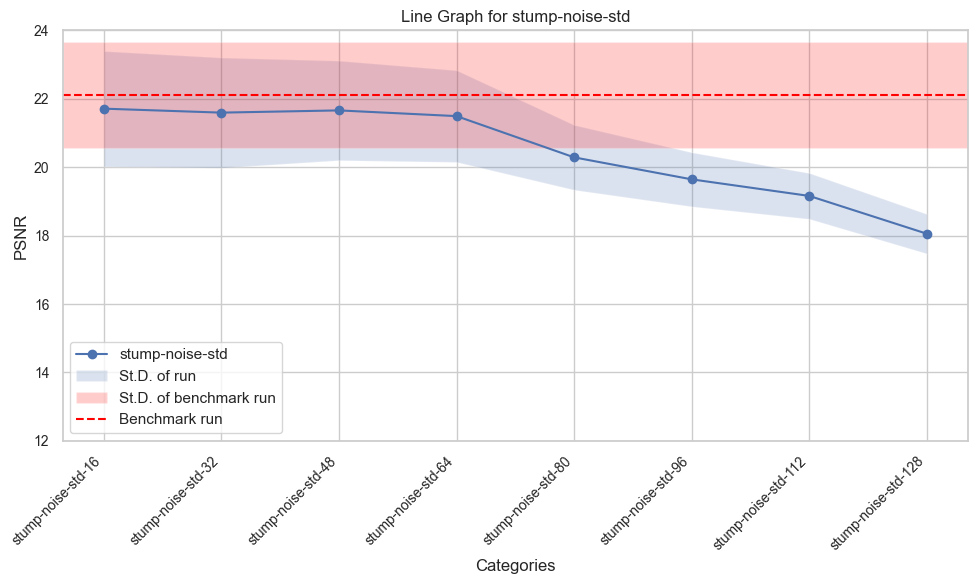

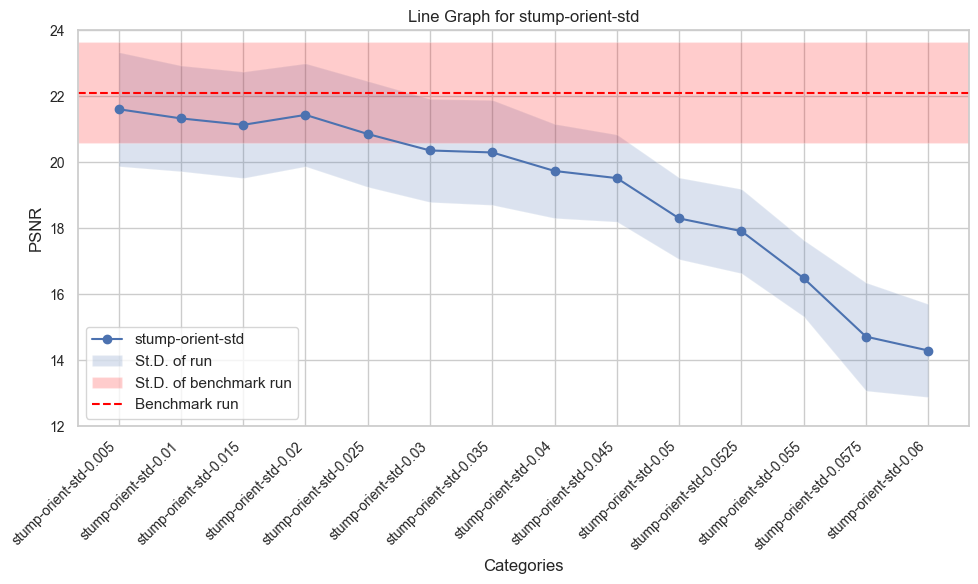

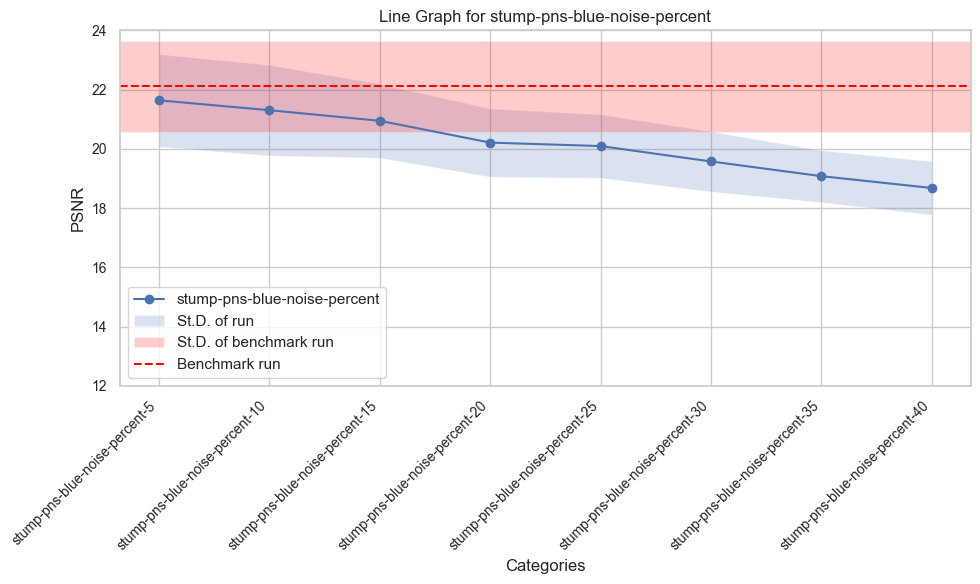

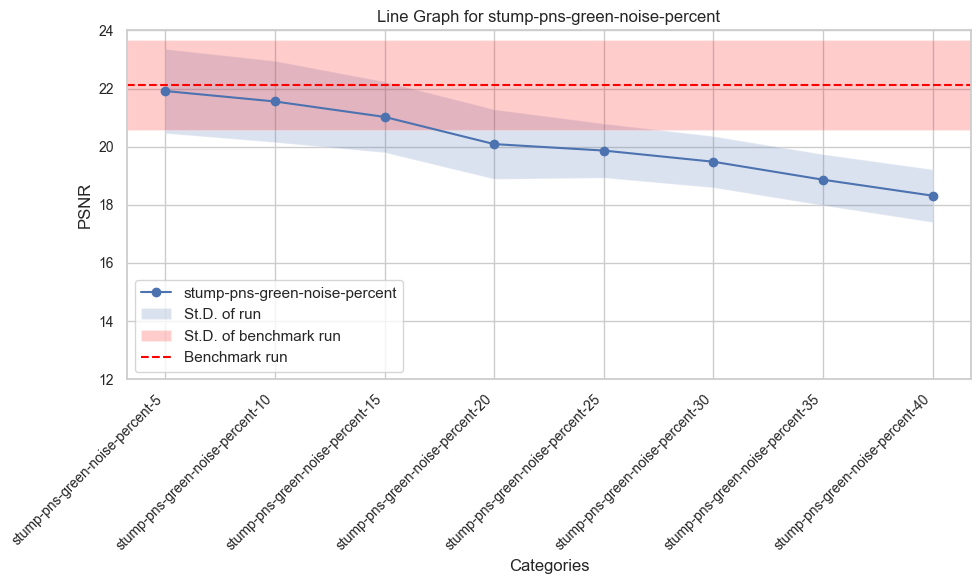

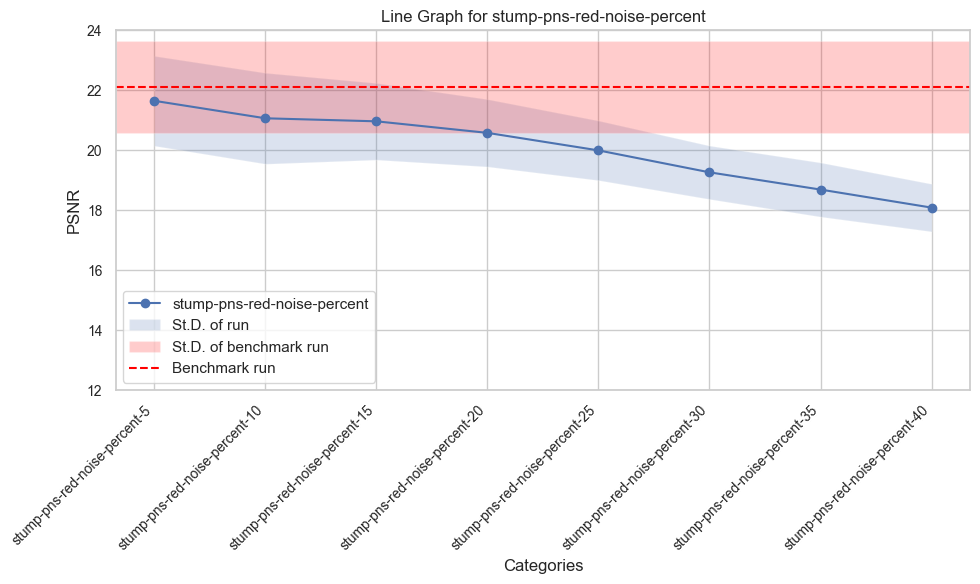

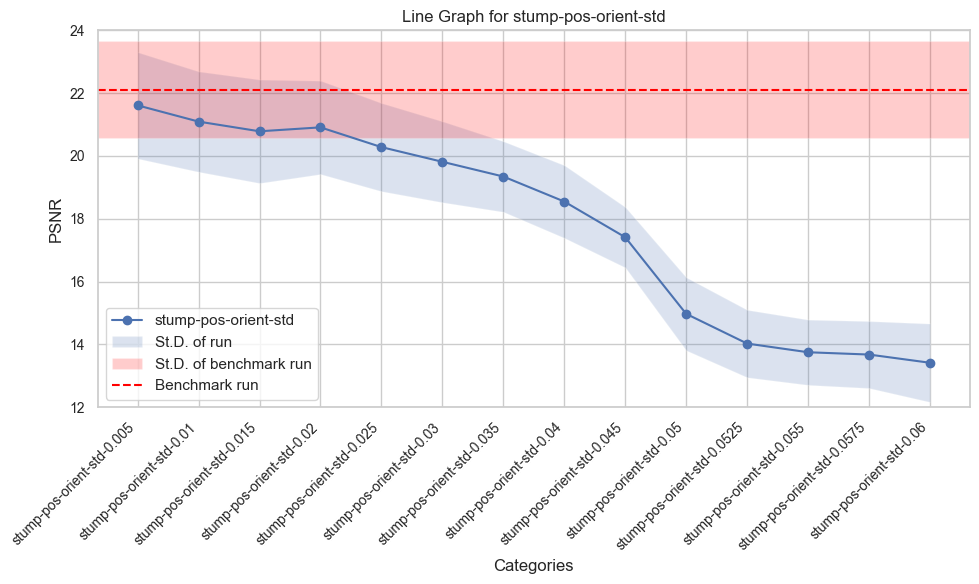

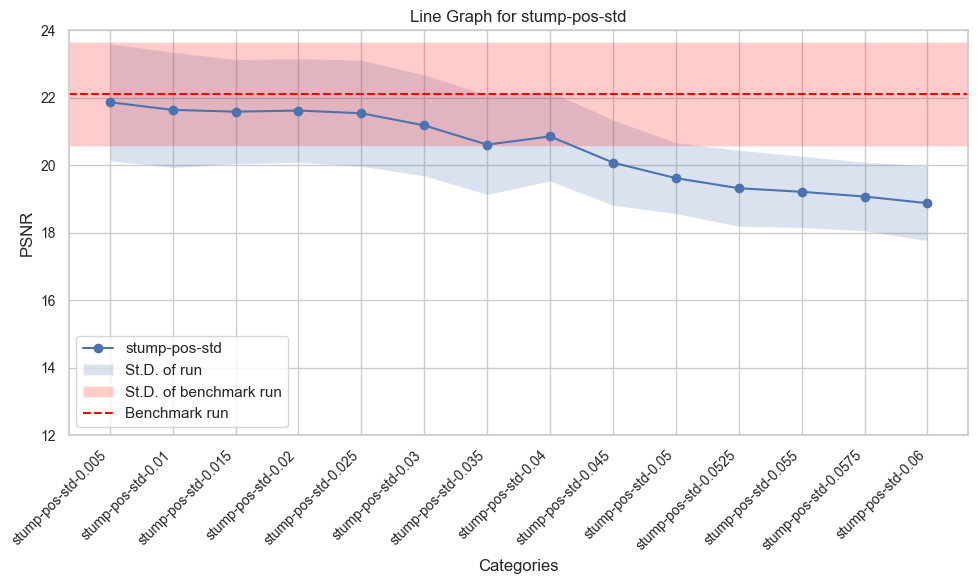

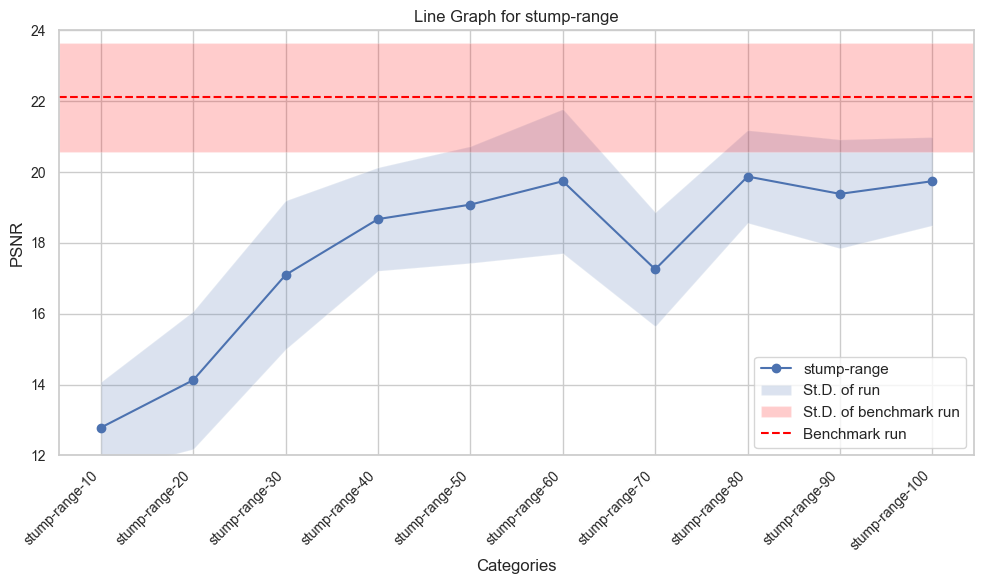

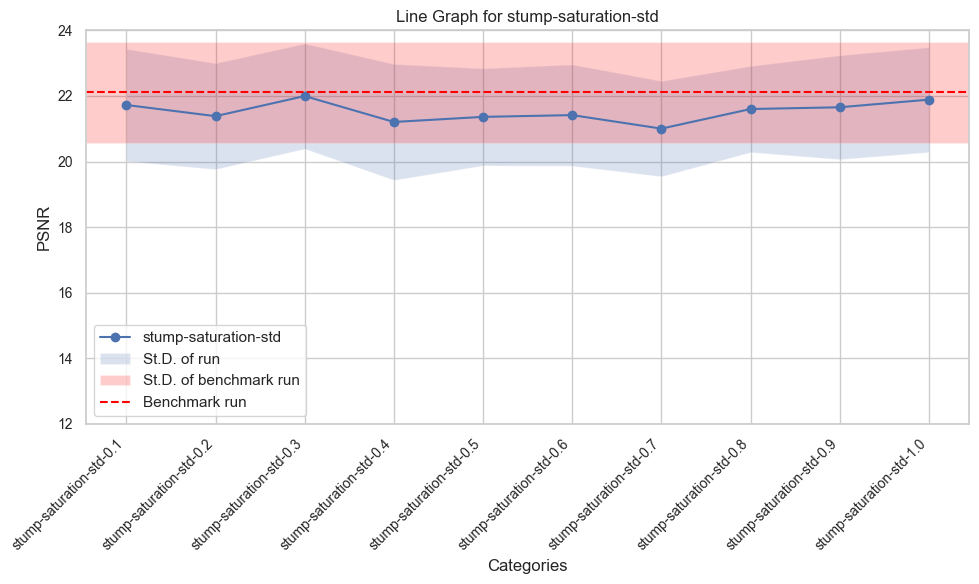

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

types = ['stump-noise-std', 'stump-orient-std', 'stump-pns-blue-noise-percent', 'stump-pns-green-noise-percent',
         'stump-pns-red-noise-percent', 'stump-pos-orient-std', 'stump-pos-std', 'stump-range',
         'stump-saturation-std']

# Set Seaborn style
sns.set(style="whitegrid", rc={"axes.labelsize": 12, "xtick.labelsize": 10, "ytick.labelsize": 10})

sorted_data = sorted(data, key=lambda x: (x[0].split('-')[1], float(x[0].split('-')[-1]), x[1]))

for type_name in types:
    type_data = [item for item in sorted_data if type_name in item[0]]
    categories, values, stds = zip(*type_data)

    # Add a red line with shaded standard deviation
    single_value = benchmark_psnr  # Replace 0 with the index of the desired value
    single_std = benchmark_psnr_std  # Replace 0 with the index of the desired standard deviation

    plt.figure(figsize=(10, 6))
    plt.plot(categories, values, marker='o', linestyle='-', label=type_name)
    plt.fill_between(categories, [value - std for value, std in zip(values, stds)],
                     [value + std for value, std in zip(values, stds)], alpha=0.2, label='St.D. of run')

    # Add a red line with shaded standard deviation
    plt.axhspan(single_value - single_std, single_value + single_std, facecolor='red', alpha=0.2, label='St.D. of benchmark run')
    plt.axhline(y=single_value, color='red', linestyle='--', label='Benchmark run')

    plt.ylim(12, 24)  # Set y-axis limits
    plt.xlabel('Categories')
    plt.ylabel('PSNR')
    plt.title(f'Line Graph for {type_name}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.legend()
    plt.tight_layout()

    plt.show()


In [12]:
'''
for all the stuff with offsets
'''

# Benchmark values for PSNR, SSIM, and LPIPS
benchmark_psnr = 22.115245819091797
benchmark_psnr_std = 1.542604923248291
benchmark_ssim = 0.654498815536499
benchmark_lpips = 0.44680535793304443

def extract_metrics(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)

    psnr = data['results']['psnr']
    ssim = data['results']['ssim']
    lpips = data['results']['lpips']

    psnr_std = data['results']['psnr_std']
    ssim_std = data['results']['ssim_std']
    lpips_std = data['results']['lpips_std']

    return psnr, ssim, lpips, psnr_std, ssim_std, lpips_std

def create_latex_table(experiment_names, psnr_values, ssim_values, lpips_values, delta_psnr, delta_ssim, delta_lpips, dino_values):
    # latex_table = "\\begin{tabular}{c|c|c|c|c|c|c}\n"
    # latex_table += "\\hline\n"
    # latex_table += "Experiment & PSNR & $\\Delta$ PSNR & SSIM & $\\Delta$ SSIM & LPIPS & $\\Delta$ LPIPS \\\\\n"
    # latex_table += "\\hline\n"
    
    latex_table = "\\begin{tabular}{c|c|c|c|c|c|c|c|c}\n"  # Added a new column for relative change in PSNR
    latex_table += "Experiment & PSNR & $\\Delta$ PSNR & Rel. Change & SSIM & $\\Delta$ SSIM & LPIPS & $\\Delta$ LPIPS & DINO Sim. \\\\\n"
    latex_table += "\\hline\n"


    for exp, psnr, ssim, lpips, delta_p, delta_s, delta_l, dino_val in zip(
        experiment_names, psnr_values, ssim_values, lpips_values, delta_psnr, delta_ssim, delta_lpips, dino_values
    ):
        exp = os.path.basename(exp)
        # latex_table += f"{exp} & {psnr:.4f} & {delta_p:.4f} & {ssim:.4f} & {delta_s:.4f} & {lpips:.4f} & {delta_l:.4f} \\\\\n"
        
        relative_delta_psnr = (delta_p / benchmark_psnr)*100  # Calculate relative change in PSNR
        latex_table += f"{exp} & {psnr:.4f} & {delta_p:.4f} & {relative_delta_psnr:.3f}\% & {ssim:.4f} & {delta_s:.4f} & {lpips:.4f} & {delta_l:.4f} & {dino_val:.4f} \\\\\n"


    # latex_table += "\\hline\n"
    latex_table += "\\end{tabular}"

    return latex_table

def calculate_deltas(values, benchmark):
    return [value - benchmark for value in values]

path_jsons = 'C:\Stuff\Dataset-creation\jsons_offset_experiments'
path_renders = "C:\Stuff\Dataset-creation\\renders"
json_files = [os.path.join(path_jsons, f) for f in os.listdir(path_jsons) if f.endswith('.json')]

experiment_names = [os.path.splitext(file)[0] for file in json_files]
psnr_values, ssim_values, lpips_values, dino_values = [], [], [], []
psnr_stds, ssim_stds, lpips_stds = [], [], []
delta_psnr, delta_ssim, delta_lpips = [], [], []
data = []

for i, json_file in enumerate(json_files):
    psnr, ssim, lpips, psnr_std, ssim_std, lpips_std = extract_metrics(json_file)
    psnr_values.append(psnr)
    ssim_values.append(ssim)
    lpips_values.append(lpips)

    psnr_stds.append(psnr_std)
    ssim_stds.append(ssim_std)
    lpips_stds.append(lpips_std)
    
    exp = os.path.basename(experiment_names[i])
    data.append([exp, psnr, psnr_std])
    # data.append([exp, psnr])



    # timestamp = extract_timestapm_from_json(json_file)
    # print(timestamp)
    # folder_renders = os.path.join(path_renders, timestamp)
    # if not os.path.exists(folder_renders):
    #     dino_sim_score = -1
    # else:
    #     dino_sim_score = dino_sim(folder_renders, original_path=original_path)
    # dino_values.append(dino_sim_score)

    dino_values.append(-1)

delta_psnr = calculate_deltas(psnr_values, benchmark_psnr)
delta_ssim = calculate_deltas(ssim_values, benchmark_ssim)
delta_lpips = calculate_deltas(lpips_values, benchmark_lpips)

latex_table = create_latex_table(
    experiment_names, psnr_values, ssim_values, lpips_values, delta_psnr, delta_ssim, delta_lpips, dino_values
)

print(latex_table)

\begin{tabular}{c|c|c|c|c|c|c|c|c}
Experiment & PSNR & $\Delta$ PSNR & Rel. Change & SSIM & $\Delta$ SSIM & LPIPS & $\Delta$ LPIPS & DINO Sim. \\
\hline
opt-off-offset-5-every-2 & 22.0091 & -0.1061 & -0.480\% & 0.6818 & 0.0273 & 0.4243 & -0.0225 & -1.0000 \\
opt-off-offset-5-every-3 & 22.1792 & 0.0639 & 0.289\% & 0.6827 & 0.0282 & 0.4177 & -0.0291 & -1.0000 \\
opt-off-offset-5-every-4 & 21.7074 & -0.4079 & -1.844\% & 0.6636 & 0.0091 & 0.4499 & 0.0031 & -1.0000 \\
opt-off-offset-5-every-5 & 12.5499 & -9.5653 & -43.252\% & 0.4239 & -0.2306 & 0.8595 & 0.4127 & -1.0000 \\
opt-off-offset-5-every-6 & 15.4118 & -6.7035 & -30.312\% & 0.5087 & -0.1458 & 0.7103 & 0.2635 & -1.0000 \\
opt-off-offset-5-every-7 & 12.4667 & -9.6486 & -43.629\% & 0.4329 & -0.2215 & 0.8697 & 0.4229 & -1.0000 \\
opt-off-offset-5-every-8 & 12.0540 & -10.0612 & -45.494\% & 0.4123 & -0.2422 & 0.8762 & 0.4294 & -1.0000 \\
opt-off-offset-every-2 & 21.8127 & -0.3025 & -1.368\% & 0.6826 & 0.0281 & 0.4187 & -0.0281 & -1.0000 \\